# Presets

In [1]:
using ReinforcementLearningBase, GridWorlds
using PyPlot

In [2]:
using Statistics

In [3]:
world = GridWorlds.GridRoomsDirectedModule.GridRoomsDirected();
env = GridWorlds.RLBaseEnv(world);

# Defining Agent

In [4]:
mutable struct Agent
    env::AbstractEnv
    algo::Symbol
    ϵ::Float64        # współczynnik eksploracji
    ϵ_decay::Float64
    ϵ_min::Float64
    β::Float64        # dyskonto
    α::Float64        # stopa uczenia się
    Q::Dict
    E::Dict           # słownik dla przechowywania pary state-action
    score::Int        # wynik - ile razy agent dotarl do mety
    steps_per_episode::Vector{Float64} # ile trwal przecietny epizod
end;

function Agent(env, algo; ϵ = 1.0, ϵ_decay = 0.9975, ϵ_min = 0.005, β = 0.99, α = 0.1) 
    Agent(env, algo, ϵ, ϵ_decay, ϵ_min, β, α, Dict(), Dict(), 0, [0.0,])
end;

# SARSA(0) functions

In [5]:
function learn!(agent, S, A, r, S′,A′)
    if !haskey(agent.Q, S)
        agent.Q[S] = zeros(length(action_space(agent.env)))
        agent.Q[S][A] = r
    else
        Q_S′ = 0.0
        haskey(agent.Q, S′) && (Q_S′ += agent.Q[S′][A′])
        agent.Q[S][A] += agent.α * (r + agent.β*Q_S′ - agent.Q[S][A])
    end
end;

In [6]:
function run_learning!(agent, steps; burning = true, animated = nothing) 
    step = 1.0
    steps_per_episode = 1.0
    episode = 1.0
    if !isnothing(animated)
        global str = ""
        global str = str * "FRAME_START_DELIMITER"
        global str = str * "step: $(step)\n"
        global str = str * "episode: $(episode)\n"
        global str = str * repr(MIME"text/plain"(), env)
        global str = str * "\ntotal_reward: 0"
    end
    while step <= steps
        if (burning && step < 0.1*steps) || rand() < agent.ϵ || !haskey(agent.Q, state(agent.env))
            A = rand(1:length(action_space(agent.env)))
        else 
            A = argmax(agent.Q[state(agent.env)])
        end
        S = deepcopy(state(agent.env))
        agent.env(action_space(agent.env)[A])
        r = reward(agent.env)
        S′ = deepcopy(state(agent.env))
        if agent.algo == :SARSA
            if (burning && step < 0.1 * steps) || rand() < agent.ϵ || !haskey(agent.Q, state(agent.env))
                A′ = rand(1:length(action_space(agent.env)))
            else 
                A′ = argmax(agent.Q[state(agent.env)])
            end
            learn!(agent, S, A, r, S′,A′)
        else
            learn!(agent, S, A, r, S′)
        end
        if !isnothing(animated) 
            global str = str * "FRAME_START_DELIMITER"
            global str = str * "step: $(step)\n"
            global str = str * "episode: $(episode)\n"
            global str = str * repr(MIME"text/plain"(), env)
            global str = str * "\ntotal_reward: $(agent.score)"
        end
        if is_terminated(agent.env)
            eps = agent.ϵ * agent.ϵ_decay
            agent.ϵ = max(agent.ϵ_min, eps)
            agent.score += 1.0
            push!(agent.steps_per_episode, 
                agent.steps_per_episode[end] + (steps_per_episode - agent.steps_per_episode[end])/episode)
            episode += 1.0
            steps_per_episode = 0
            reset!(agent.env)
        end
        step += 1.0 
        steps_per_episode += 1.0
    end
    if !isnothing(animated) 
        write(animated * ".txt", str)
    end
end;

# SARSA(λ) functions

In [7]:
function check_visualization(env, agent, animated, step, episode)
    if !isnothing(animated)
        global str = ""
        global str = str * "FRAME_START_DELIMITER"
        global str = str * "step: $(step)\n"
        global str = str * "episode: $(episode)\n"
        global str = str * repr(MIME"text/plain"(), env)
        global str = str * "\ntotal_reward: $(agent.score)"
    end
end;

function make_action(agent, burning, step, steps)
    if (burning && step < 0.1*steps) || rand() < agent.ϵ || !haskey(agent.Q, state(agent.env))
        A = rand(1:length(action_space(agent.env)))
    else 
        A = argmax(agent.Q[state(agent.env)])
    end
    return A
end;

function check_Q!(agent, S, A, S′, A′, r)
    if !haskey(agent.Q, S)
        agent.Q[S] = zeros(length(action_space(agent.env)))
    end
    if !haskey(agent.Q, S′)
        agent.Q[S′] = zeros(length(action_space(agent.env)))
    end
end;

function check_E!(agent, S)
    if !haskey(agent.E, S)
        agent.E[S] = zeros(length(action_space(agent.env)))
    end
end;

In [8]:
function run_learning_lambda!(agent; steps = 250_000, λ = 1, burning = true, animated = nothing)
    step = 1.0
    steps_per_episode = 1.0
    episode = 1.0
    check_visualization(env, agent, animated, step, episode)
    
    while step <= steps
        S = deepcopy(state(agent.env))                  # stan pierwotny
        A = make_action(agent, burning, step, steps)    # wybierz akcję na podstawie strategii
        agent.env(action_space(agent.env)[A])           # zrób akcję
        r = reward(agent.env)                           # przypisz nagrodę
        S′ = deepcopy(state(agent.env))                 # oblicz kolejny stan
        A′ = make_action(agent, burning, step, steps)   # wybierz kolejną akcję
            
        check_Q!(agent, S, A, S′, A′, r)     # sprawdź czy istnieją nagrody dla stanów S i S′       
        # oblicz deltę (temporal difference, TD)
        δ = r + agent.β*agent.Q[S′][A′] - agent.Q[S][A]
        check_E!(agent, S)                   # sprawdź czy istnieje licznik akcji dla stanu S
        agent.E[S][A] += 1                   # uaktulizuj licznik akcji A dla stanu S
            
        check_visualization(env, agent, animated, step, episode)
            
        # dla każdego stanu uaktualizuj licznik oraz nagrody
        for s = 1:length(length(agent.Q))
            for a = 1:length(action_space(agent.env))
                agent.Q[S][A] = agent.Q[S][A] + agent.α*δ*agent.E[S][A]
                agent.E[S][A] = agent.β*λ*agent.E[S][A]
            end
        end
            
        # przejdź do kolejnego stanu
        S = deepcopy(S′) 
        A = deepcopy(A′)
            
        # sprawdź warunek terminacji
        if is_terminated(agent.env)
            eps = agent.ϵ * agent.ϵ_decay       # uaktulizuj skłoność do losowego przeszukiwania
            agent.ϵ = max(agent.ϵ_min, eps)
            agent.score += 1.0                  # uaktualizuj licznik wygranych gier
            push!(
                agent.steps_per_episode,
                (agent.steps_per_episode[end] + 
                (steps_per_episode - agent.steps_per_episode[end])/episode)
            )
            episode += 1.0
            steps_per_episode = 0
            # zresetuj agenta i przejdz do kolejnego epizodu(jeżeli jeszcze są)
            reset!(agent.env) 
            continue
        end
        step += 1.0 
        steps_per_episode += 1.0
    end
    if !isnothing(animated) 
        write(animated * ".txt", str)
    end
end;

# Comparing SARSAs

In [9]:
n_steps = 250_000

agent_SARSA0 = Agent(env,:SARSA);
run_learning!(agent_SARSA0, n_steps)
@info "agent(λ=0) score: $(agent_SARSA0.score)"

agent_SARSA025 = Agent(env,:SARSA);
run_learning_lambda!(agent_SARSA025, steps=n_steps, λ = 0.25)
@info "agent(λ=0.25) score: $(agent_SARSA025.score)"

agent_SARSA05 = Agent(env,:SARSA);
run_learning_lambda!(agent_SARSA05, steps=n_steps, λ = 0.5)
@info "agent(λ=0.5) score: $(agent_SARSA05.score)"

agent_SARSA075 = Agent(env,:SARSA);
run_learning_lambda!(agent_SARSA075, steps=n_steps, λ = 0.75)
@info "agent(λ=0.75) score: $(agent_SARSA075.score)"

agent_SARSA1 = Agent(env,:SARSA);
run_learning_lambda!(agent_SARSA1, steps=n_steps, λ = 0.1)
@info "agent(λ=1) score: $(agent_SARSA1.score)"

[ Info: agent(λ=0) score: 661
[ Info: agent(λ=0.25) score: 672
[ Info: agent(λ=0.5) score: 729
[ Info: agent(λ=0.75) score: 668
[ Info: agent(λ=1) score: 710


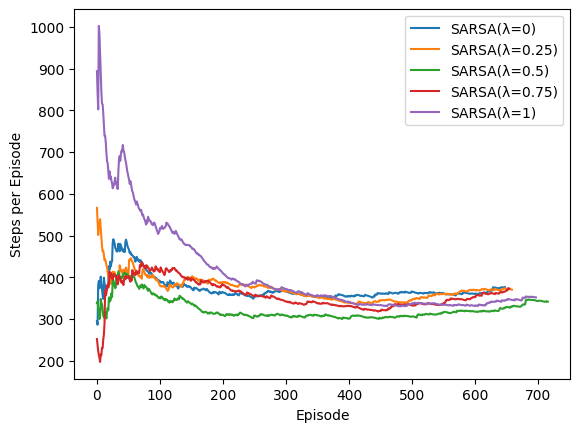

PyObject Text(0.5, 24.0, 'Episode')

In [10]:
PyPlot.plot(agent_SARSA0.steps_per_episode[15:end], label = "SARSA(λ=0)")
PyPlot.plot(agent_SARSA025.steps_per_episode[15:end], label = "SARSA(λ=0.25)")
PyPlot.plot(agent_SARSA05.steps_per_episode[15:end], label = "SARSA(λ=0.5)")
PyPlot.plot(agent_SARSA075.steps_per_episode[15:end], label = "SARSA(λ=0.75)")
PyPlot.plot(agent_SARSA1.steps_per_episode[15:end], label = "SARSA(λ=1)")
legend()
ylabel("Steps per Episode")
xlabel("Episode")

In [11]:
println("Mean steps per episode")
println("SARSA(λ=0): ", round(mean(agent_SARSA0.steps_per_episode)))
println("SARSA(λ=0.25): ", round(mean(agent_SARSA025.steps_per_episode)))
println("SARSA(λ=0.5): ", round(mean(agent_SARSA05.steps_per_episode)))
println("SARSA(λ=0.75): ", round(mean(agent_SARSA075.steps_per_episode)))
println("SARSA(λ=1): ", round(mean(agent_SARSA1.steps_per_episode)))

Mean steps per episode
SARSA(λ=0): 371.0
SARSA(λ=0.25): 382.0
SARSA(λ=0.5): 325.0
SARSA(λ=0.75): 355.0
SARSA(λ=1): 417.0


In [12]:
println("Median steps per episode")
println("SARSA(λ=0): ", round(median(agent_SARSA0.steps_per_episode)))
println("SARSA(λ=0.25): ", round(median(agent_SARSA025.steps_per_episode)))
println("SARSA(λ=0.5): ", round(median(agent_SARSA05.steps_per_episode)))
println("SARSA(λ=0.75): ", round(median(agent_SARSA075.steps_per_episode)))
println("SARSA(λ=1): ", round(median(agent_SARSA1.steps_per_episode)))

Median steps per episode
SARSA(λ=0): 363.0
SARSA(λ=0.25): 370.0
SARSA(λ=0.5): 314.0
SARSA(λ=0.75): 349.0
SARSA(λ=1): 357.0


Na podstawie powyższych wyników można stwierdzić, że dla rozważanego problemu GridWorlds najbardziej efektywnym okazał się model SARSA z współczynnikiem λ = 0.5. Świadczy o tym całkowita nagroda agenta (score), skoro mianowicie dla parametru lambda = 0.5 liczba skończonych gier (epizodów) była największą (729). Co więcej, powyższe potwierdza medialna i średnia liczba kroków per epizod. Skoro celem uczenia w tym przykładzie jest jak najszybciej możliwe wygranie, lepszym modelem jest ten, dla którego liczba kroków (średnia czy medialna) jest mniejsza, bo wtedy więcej potencjalnych kroków algorytmu pozostaje na ukończenie innych epizodów. Ostatnim wzmocnieniem tego jest wykres kroków per epizod vs liczba kroków. Widać ze wartość kroków per epizod przyjmuje najmniejsze wartości mianowicie dla λ = 0.5, zaczynając od ~ 160-go epizodu.

Warto jednak zauważyć, że otrzymane wyniki mogli zostać osiągnięte przypadkowo. Np. średnia różnica (371-325)/325 = 14.15% nie jest zbyt duża i może wynikać z losowego charakteru uczenia.